In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

In [331]:
X, y = make_classification(1000, 10, class_sep=6, n_classes=2, n_redundant=3, n_informative=7, n_clusters_per_class=4, flip_y=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

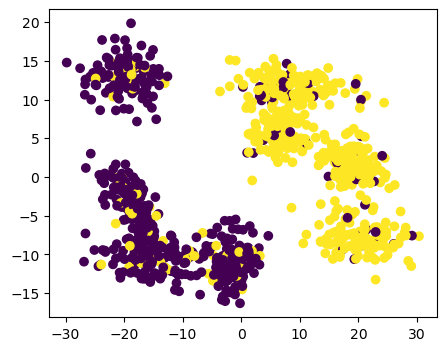

In [332]:
pca = PCA(2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(5, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y);

# AdaBoost

In [333]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1):
        self.n_estimators = n_estimators
        self.lr = learning_rate
    
    def fit(self, X, y):
        weights = np.ones(len(y)) / len(y)
        self.coefficients = []
        self.estimators = []
        self.n_classes = len(np.unique(y))
        for t in range(self.n_estimators):
            estimator = DecisionTreeClassifier(max_depth=1)
            pred = estimator.fit(X, y, sample_weight=weights).predict(X)
            err_indexes = pred != y #индексы объектов, на которых модель ошиблась
            error = np.sum(weights[err_indexes]) #считаем долю ошибок, учитывая веса объектов, на которых модель ошиблась
            coeff = self.lr * np.log( (1-error)/error ) + np.log(self.n_classes - 1) #чем ниже ошибка, тем с большим весом будет конкретный estimator 
            weights[err_indexes] *= np.exp(coeff) #если ошибка была большой, то веса этих объектов из выборки увеличатся (эти объекты в дальнейшем учитываются сильнее)
            weights = weights / np.sum(weights) #веса объектов в сумме должны давать 1
            self.coefficients.append(coeff)
            self.estimators.append(estimator)
    
    def predict(self, X):
        n_samples = len(X)
        sample_indexes = np.array(range(n_samples))
        prediction_weights = np.zeros((n_samples, self.n_classes))

        for i in range(self.n_estimators):
            prediction = self.estimators[i].predict(X).astype(int)
            prediction_weights[sample_indexes, prediction] += self.coefficients[i]

        return np.argmax(prediction_weights, axis=1)
            

In [334]:
boosting = AdaBoost(n_estimators=100)
boosting.fit(X_train, y_train)

In [335]:
accuracy_score(y_test, boosting.predict(X_test))

0.9

In [336]:
AdaBoostClassifier(n_estimators=100, algorithm="SAMME").fit(X_train, y_train).score(X_test, y_test)

0.9

# Градиентный бустинг для регрессии

In [337]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
    
    def fit(self, X, y):
        pred = np.mean(y) 
        self.start_pred = pred
        for _ in range(self.n_estimators):
            antigrad = y - pred
            estimator = DecisionTreeRegressor(max_depth=self.max_depth)
            estimator.fit(X, antigrad)
            pred += self.learning_rate * estimator.predict(X)
            self.estimators.append(estimator)
        return self
    
    def predict(self, X):
        pred = self.start_pred * np.ones(len(X))
        for i in range(self.n_estimators):
            pred += self.learning_rate * self.estimators[i].predict(X)
        return pred

In [338]:
X, y = make_regression(n_samples=1000, n_features=10, noise=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [339]:
boosting = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1)
boosting.fit(X_train, y_train);

In [340]:
mean_absolute_error(y_test, boosting.predict(X_test))

21.4318633618679

In [341]:
train_errors = []
test_errors = []
l = [5, 10, 50, 100, 200, 500, 1000, 2500]
for n in l:
    est = GradientBoostingRegressor(n_estimators=n).fit(X_train, y_train)
    train_errors.append(mean_absolute_error(y_train, est.predict(X_train)))
    test_errors.append(mean_absolute_error(y_test, est.predict(X_test)))

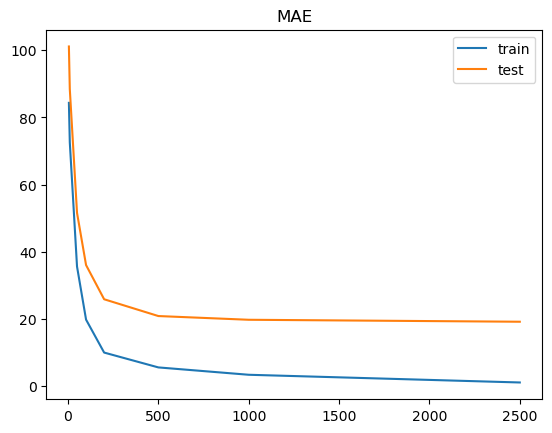

In [342]:
plt.plot(l, train_errors, label="train")
plt.plot(l, test_errors, label="test")
plt.legend();
plt.title("MAE");

# Градиентный бустинг для бинарной классификации

$ $

$LogLoss = -y_i \cdot log(p_i)-(1-y_i)\cdot log(1-p_i) = -y_i \cdot log(odds) + log(1+e^{log(odds)}) $

$log(odds) = log(\frac{p_i}{1-p_i})$

$Antigradient = y_i - p_i$ берется по $log(odds)$

В качестве выходных значений дерева берется не среднее значение элементов в листе, как в случае регрессии, а велечина, которая считается по формуле: 

$γ = {argmin}_γ(\sum_{x_i∈R}LogLoss(y_i, F_{m-1}(x_i)+γ)),$ где $R$ - конкретный лист дерева$, F_{m-1}$ - предыдущее значение $log(odds)$ для конкретного $x_i,$ то есть находится такая $γ,$ которая минимизирует $LogLoss$ для всех $x_i,$ которые входят в $R$

Можно взять производную, чтобы найти $γ$, но так будет сложно, поэтому обычно функция приближается рядом Тейлора 2-го порядка и в итоге получается: 

$γ = -\frac{\sum_{x_i∈R}(y_i-p_i)}{\sum_{x_i∈R}p_i \cdot (1-p_i)}$ для каждого листа дерева

Далее происходит шаг градиентного бустинга с помощью подобранного значения $γ$

$ $


In [221]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.train_logloss = []
    
    def sigma(self, x): #Логистическая функция
        return 1 / (1 + np.exp(-x))
    
    def log_odds(self, p): #Получить логарифм шансов из вероятности
        return np.log(p / (1-p))
    
    def logloss(self, y, log_odds):
        return np.sum(-y*log_odds+np.log(1+np.exp(log_odds)))
        
    def fit(self, X, y, eval_set=None):
        self.start_pred = self.log_odds(np.mean(y)) 
        pred = self.start_pred * np.ones(len(y)) #Начальное предсказание равно логарифму шансов от усредненной вероятности y
        
        if eval_set:
            self.eval_logloss = []
            X_val, y_val = eval_set
            eval_pred = self.start_pred * np.ones(len(y_val))
        
        for _ in range(self.n_estimators):
            antigrad = y - self.sigma(pred) #Антиградиент логистической функции потерь
            estimator = DecisionTreeRegressor(max_depth=self.max_depth) 
            estimator.fit(X, antigrad) #Обучаем дерево на X и антиградиенте
            leaf_indexes = estimator.apply(X) #Получаем индексы листьев дерева размерности y. Указывает, к какому листу относится каждая строка из X
            
            for j in np.unique(leaf_indexes): #Проходимся по каждому листку
                indexes = (leaf_indexes == j) #Находим все индексы из строк X, которые вошли в конкретный лист
                residual_sum = np.sum(antigrad[indexes]) #Считаем сумму остатков 
                p = self.sigma(pred)[indexes] #Получаем вероятности, соответствующие конкретным индексам строк X 
                denominator = np.sum(p * (1-p)) #Вычисляем знаменатель дроби
                estimator.tree_.value[j, 0, 0] = residual_sum / denominator #Меняем старые значения листьев на новые
            
            pred += self.learning_rate * estimator.predict(X) #Шаг градиентного бустинга        
            self.estimators.append(estimator)
            self.train_logloss.append(self.logloss(y, pred))
            
            if eval_set:
                eval_pred += self.learning_rate * estimator.predict(X_val)
                self.eval_logloss.append(self.logloss(y_val, eval_pred))
                
        return self
    
    def predict_proba(self, X): 
        pred = self.start_pred * np.ones(len(X))
        for i in range(self.n_estimators):
            pred += self.learning_rate * self.estimators[i].predict(X)
        return self.sigma(pred)

In [252]:
X, y = make_classification(10000, 10, class_sep=2, n_classes=2, n_redundant=3, n_informative=7, n_clusters_per_class=4, flip_y=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)

In [259]:
gbc = GradientBoostingClassifier(n_estimators=2500, max_depth=5, learning_rate=0.05)
gbc.fit(X_train, y_train, eval_set=(X_test, y_test));

In [272]:
roc_auc_score(y_test, gbc.predict_proba(X_test))

0.8991725470430108

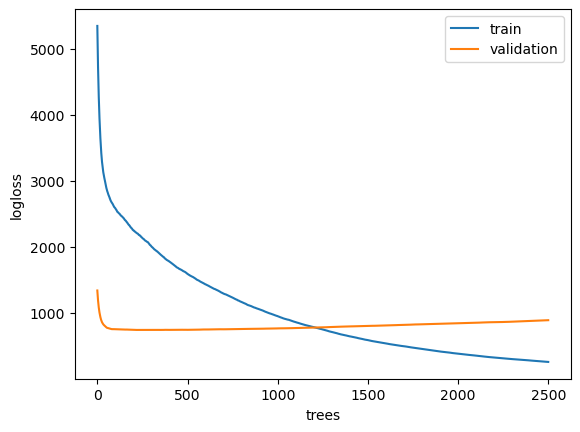

In [261]:
plt.plot(range(gbc.n_estimators), gbc.train_logloss, label="train");
plt.plot(range(gbc.n_estimators), gbc.eval_logloss, label="validation");
plt.legend()
plt.xlabel("trees");
plt.ylabel("logloss");

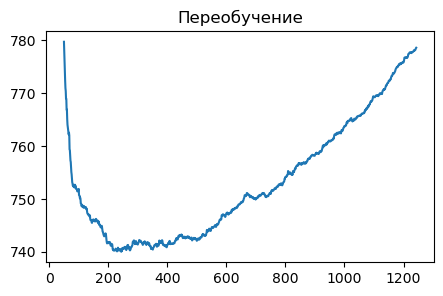

In [267]:
plt.figure(figsize=(5, 3))
plt.title("Переобучение")
stop = np.argmin(gbc.eval_logloss) + 1000
start = 50
plt.plot(range(start, stop), gbc.eval_logloss[start:stop], label="validation");